## Python statistics essential training - 03_08_email

Standard imports

In [1]:
import numpy as np
import scipy.stats
import pandas as pd

In [2]:
import matplotlib
import matplotlib.pyplot as pp

import pandas.plotting

from IPython import display
from ipywidgets import interact, widgets

%matplotlib inline

In [3]:
import re
import mailbox
import csv

### How I converted my mailbox.

takeout.google.com/settings/takeout
For purpose of this exercise, I exported only emails labeled as promotions

In [12]:
#mbox = mailbox.mbox('Sent.mbox')
mbox = mailbox.mbox('CategoryPromotions.mbox')

In [17]:
len(mbox)
mbox.shape

AttributeError: 'mbox' object has no attribute 'shape'

The resulting object is array-like, with one entry per message. Each entry is dictionary like, with keys corresponding to metadata and data for each message.

In [14]:
mbox[0].keys()

['X-GM-THRID',
 'X-Gmail-Labels',
 'Delivered-To',
 'Received',
 'X-Google-Smtp-Source',
 'X-Received',
 'ARC-Seal',
 'ARC-Message-Signature',
 'ARC-Authentication-Results',
 'Return-Path',
 'Received',
 'Received-SPF',
 'Authentication-Results',
 'Received',
 'DKIM-Filter',
 'DKIM-Signature',
 'Received',
 'Date',
 'To',
 'MIME-Version',
 'Reply-to',
 'From',
 'X-campaignid',
 'List-Unsubscribe',
 'Message-Id',
 'X-Recipient-User-Id',
 'X-Campaign-Data',
 'Feedback-ID',
 'Content-Type',
 'Content-Transfer-Encoding',
 'Subject']

The easiest way to get these data into Pandas is to build a CSV file from them. We use the module `csv` to write out the CSV file as we loop over the mailbox object. We save only subject, from, to, and date, and we write a simple header at the top with the names of columns.

In [15]:
with open('mbox.csv', 'w') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['subject','from','to','date'])
    
    for message in mbox:
        writer.writerow([message['subject'], message['from'], message['to'], message['date']])

All done! Thanks to Justin Ellis for inspiration with https://jellis18.github.io/post/2018-01-17-mail-analysis.

## Moving on!

In [18]:
import pandas as pd

In [19]:
#instead, use the anonymized example from the 
messages = pd.read_csv('mbox-anonymized.csv')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   subject  1030 non-null   object
 1   from     1029 non-null   object
 2   to       1030 non-null   object
 3   date     1030 non-null   object
dtypes: object(4)
memory usage: 32.3+ KB


In [20]:
messages.head()

,subject,from,to,date
0,Why control quickly exactly capital.,"""Vallisneri, Michele (335S)"" <Michele.Vallisne...","""Trevor Charles"" <zrodriguez@hotmail.com>","Mon, 27 Nov 2017 14:18:46 -0800"
1,Work evidence from really threat sign store see.,Michele Vallisneri <Michele.Vallisneri@jpl.nas...,"""Heather Hernandez"" <patriciagarcia@garcia-car...","Mon, 26 Mar 2018 18:38:16 -0700"
2,Lot where answer the law person.,"""Vallisneri, Michele (335S)"" <michele.vallisne...",Bryce Dudley <hailey63@frazier.com>,"Tue, 13 Feb 2018 22:54:50 +0000"
3,Difference hotel yard.,"""Vallisneri, Michele (335S)"" <Michele.Vallisne...",Kathryn Mathis <josephrebecca@grimes.com>,"Fri, 26 Jan 2018 11:40:04 -0800"
4,Long level mission energy candidate.,"""Vallisneri, Michele (335S)"" <michele.vallisne...","""Angela Mendoza"" <rkhan@yahoo.com>","Tue, 31 Oct 2017 00:13:00 +0000"


In [24]:
#we see from the messages that the from is formatted "irregularly", e.x:
messages['from'][0]

'"Vallisneri, Michele (335S)" <Michele.Vallisneri@jpl.nasa.gov>'

In [27]:
#we can use a regex to normalize the format so that only the email addy returns
re.search('<(.+>)',messages['from'][0])

<re.Match object; span=(29, 62), match='<Michele.Vallisneri@jpl.nasa.gov>'>

We see that this expression matches, we only retain the inner email addy

In [29]:
#use group to just return the matched value
re.search('<(.+>)',messages['from'][0]).group(0)

'<Michele.Vallisneri@jpl.nasa.gov>'

In [30]:
re.search('<(.+>)',messages['from'][0]).group(1)

'Michele.Vallisneri@jpl.nasa.gov>'

We can write a simple function to clean an email address

In [42]:
def clean_address(raw):
    match = re.search('<(.+>)',raw)
    
    #meaning there is no match, then just return the string as is
    if match is None:
        
        return raw
    else:
        return match.group(1)

In [44]:
clean_address(messages['from'][0])

'Michele.Vallisneri@jpl.nasa.gov>'

In [45]:
#works - we can apply this to the entire dataframe column
messages['from'] = messages['from'].apply(clean_address)

TypeError: expected string or bytes-like object

In [46]:
#seems like an error - we can use debug to find out where the issue occurred
%debug

> /opt/anaconda3/lib/python3.7/re.py(183)search()
    181     """Scan through string looking for a match to the pattern, returning
    182     a Match object, or None if no match was found."""
--> 183     return _compile(pattern, flags).search(string)
    184 
    185 def sub(pattern, repl, string, count=0, flags=0):



ipdb>  up


> <ipython-input-42-d355a00b30f5>(2)clean_address()
      1 def clean_address(raw):
----> 2     match = re.search('<(.+>)',raw)
      3 
      4     #meaning there is no match, then just return the string as is
      5     if match is None:



ipdb>  print(raw)


nan


ipdb>  quit


Debug mode shows us the string that got us into trouble. It looks like there was a missing entry. We can remedy this by just dropping the missing value.

In [47]:
#we can chain dropna followed by applying the clean_address function
#we can apply to both the from and to columns
messages['from'] = messages['from'].dropna().apply(clean_address)
messages['to'] = messages['to'].dropna().apply(clean_address)

In [48]:
messages.head()

,subject,from,to,date
0,Why control quickly exactly capital.,Michele.Vallisneri@jpl.nasa.gov>,zrodriguez@hotmail.com>,"Mon, 27 Nov 2017 14:18:46 -0800"
1,Work evidence from really threat sign store see.,Michele.Vallisneri@jpl.nasa.gov>,patriciagarcia@garcia-carney.com>,"Mon, 26 Mar 2018 18:38:16 -0700"
2,Lot where answer the law person.,michele.vallisneri@jpl.nasa.gov>,hailey63@frazier.com>,"Tue, 13 Feb 2018 22:54:50 +0000"
3,Difference hotel yard.,Michele.Vallisneri@jpl.nasa.gov>,josephrebecca@grimes.com>,"Fri, 26 Jan 2018 11:40:04 -0800"
4,Long level mission energy candidate.,michele.vallisneri@jpl.nasa.gov>,rkhan@yahoo.com>,"Tue, 31 Oct 2017 00:13:00 +0000"


In [54]:
#We can change the date column to a datetime format
#We also need to localize to univeral time zone, and convert to local time zone
pd.to_datetime(messages['date'][0]) #.tz_localize('UTC')

Timestamp('2017-11-27 14:18:46-0800', tz='pytz.FixedOffset(-480)')

In [55]:
pd.to_datetime(messages['date'][0]).tz_localize('UTC')

TypeError: Cannot localize tz-aware Timestamp, use tz_convert for conversions

In [56]:
pd.to_datetime(messages['date'][0]).tz_convert('America/Los_Angeles')

Timestamp('2017-11-27 14:18:46-0800', tz='America/Los_Angeles')

In [57]:
#we can apply this to_datetime conversion on entire date column
messages['date'] = messages['date'].apply(lambda s: pd.to_datetime(s).tz_convert('America/Los_Angeles'))

In [58]:
messages.date.head()

0   2017-11-27 14:18:46-08:00
1   2018-03-26 18:38:16-07:00
2   2018-02-13 14:54:50-08:00
3   2018-01-26 11:40:04-08:00
4   2017-10-30 17:13:00-07:00
Name: date, dtype: datetime64[ns, America/Los_Angeles]

In [69]:
messages.date.min(), messages.date.max()

(Timestamp('2017-06-30 23:26:52-0700', tz='America/Los_Angeles'),
 Timestamp('2018-05-13 08:40:20-0700', tz='America/Los_Angeles'))

In [61]:
#day of week -- (this has to be updated from solution to newer pandas version
messages['date'].dt.day_name().head()

0     Monday
1     Monday
2    Tuesday
3     Friday
4     Monday
Name: date, dtype: object

In [62]:
#we can create a categorical variable in the df like so:
messages['dayofweek'] = pd.Categorical(messages['date'].dt.day_name(),
                                       ordered=True,
                                       categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

In [63]:
messages.dayofweek.head()

0     Monday
1     Monday
2    Tuesday
3     Friday
4     Monday
Name: dayofweek, dtype: category
Categories (7, object): [Monday < Tuesday < Wednesday < Thursday < Friday < Saturday < Sunday]

In [64]:
#time of day
messages['timeofday'] = messages['date'].dt.hour + messages['date'].dt.minute / 60

In [65]:
#fractional year -- Fractional time is the year + (the value (minute of year) / number of minutes in the year).
messages['nyear'] = messages['date'].dt.year + messages['date'].dt.dayofyear/365.25 + messages['timeofday']/24/365.25 

In [68]:
messages[['timeofday','nyear']].head()

,timeofday,nyear
0,14.300000,2017.907860
1,18.633333,2018.234843
2,14.900000,2018.122165
3,11.666667,2018.072515
4,17.216667,2017.831533


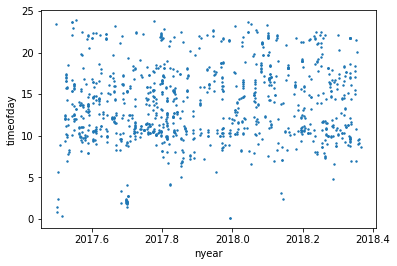

In [70]:
#plot date against time of day
messages.plot.scatter('nyear','timeofday',s=2)

This looks reasonable with few emails a night, and many in the morning. Some in the very early morning may be related to trips overseas. We can also look at one-dimensional histograms

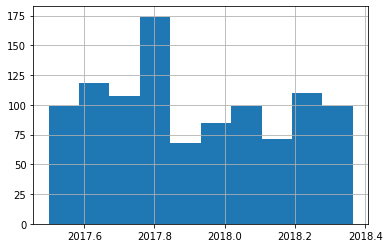

In [71]:
messages.nyear.hist()

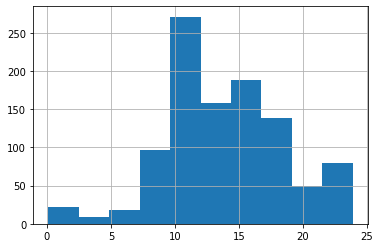

In [72]:
messages.timeofday.hist()

most active hours are during the day with a peak just before lunch.

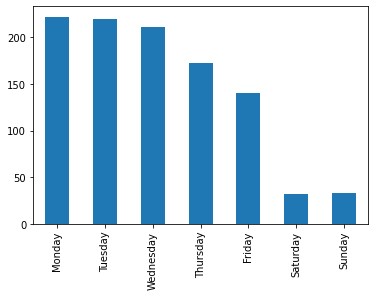

In [73]:
counts = messages.dayofweek.value_counts(sort=False) 
counts.plot(kind='bar')

(Monday is the busiest. On Fridays I'm tired and on the weekend I rest.)